### Simulation

Simulation of homogeneous Poisson point process.

In [14]:
import numpy as np

def sample_exponential_numpy(lambda_rate):
    return np.random.exponential(1 / lambda_rate)

def sample_exponential_inverse_transform(lambda_rate):
    u = np.random.uniform(0, 1)
    return -np.log(1 - u) / lambda_rate

def sample_exponential_discretization(lambda_rate, dt=0.01):
    t = 0
    while True:
        t += dt
        if np.random.uniform(0, 1) < lambda_rate * dt:
            return t
        
def sample_exponential_rescale(lambda_rate):
    sample = np.random.exponential(1)
    return sample / lambda_rate

In [15]:
def sample_homogeneous_point_process(h = 10.0, lambda_rate = 1.0):
    # Input: time horizon h > 0, rate lambda > 0
    # Output: list of event times
    events = []
    t = 0
    while t < h:
        # Generate the time to the next event using the exponential distribution
        # !!! In Numpy, the exponential distribution is parameterized with the mean, not the rate. !!!
        delta_t = sample_exponential_numpy(lambda_rate)
        t += delta_t # Update the current time
        if t < h:     # If the updated time is within the time horizon, add it to the list
            events.append(t)
    return events

# Example usage:
time_horizon = 10  # Time horizon h > 0
rate_lambda = 2    # Rate lambda > 0
sample = sample_homogeneous_point_process(time_horizon, rate_lambda)
print("Sampled event times:", sample)


Sampled event times: [0.09191517482172781, 0.13496377975308715, 0.5454649137584254, 1.000241368640632, 1.0291594626128984, 1.0816703937473175, 1.2441517596567886, 1.3045352469919311, 1.365237718961068, 3.897213495406589, 4.026212824334105, 4.316976563476079, 4.870358999549454, 5.6828316758688135, 6.03784176292136, 6.139281857325777, 6.767364779736147, 7.196728641915186, 8.68818347008537, 9.384891974666717, 9.992303797492285]


### Non-homogeneous Poisson point process

In [ ]:
import numpy as np

def sample_event_time(intensity_func, events, h, step_size):
    t = 0
    while True:
        t += step_size
        prob = intensity_func(t, events) * step_size
        if np.random.random() < prob:
            return t
        if t > h:
            return h

def sample_inhomogeneous_point_process(h, intensity_func, step_size=0.001):
    # Input: time horizon h > 0, intensity function
    # Output: list of event times
    events = []
    t = 0
    while t < h:
        t_next = sample_event_time(intensity_func, events, h, step_size)
        t += t_next
        if t < h:  # If the updated time is within the time horizon, add it to the list
            events.append(t)
    return events

# Example intensity function
def example_intensity_func(t, events):
    # A simple intensity function that increases with the number of past events
    base_rate = 1.0 if t < 0.5 else 10.0
    return base_rate + 0.1 * len(events)

# Example usage
time_horizon = 10.  # Time horizon h > 0
sample = sample_inhomogeneous_point_process(time_horizon, example_intensity_func)
print("Sampled event times:", sample)


### Thinning

Simulated event times: [0.501224022088428, 0.8441673715159298, 0.9596232131677072, 1.0409498796440617, 1.156091501548081, 1.4846227288335145, 1.543789919688292, 1.637653481572447, 1.9273681441660202, 1.9938628614094518, 2.0611764114407456, 2.141910845358021, 2.2663740623137345, 2.2945058514703773, 2.30693711913151, 2.562761204958618, 2.6901563321270854, 3.0053395553547557, 3.0130395588784364, 3.227922275458138, 3.986694195612774, 4.079676935061707, 4.1119707422414, 4.800936426858971, 4.811230236195153, 4.837670162091252, 4.912501021409247, 4.996709245345034, 5.179061040962182, 5.408145789825244, 5.652027611818871, 5.85207123715512, 6.357283780873583, 6.412829804298998, 6.642765226137298, 6.832007500997399, 6.8628848399983875, 6.866623418311156, 6.916882269562655, 7.067190505569086, 7.320780003166382, 7.433620229493955, 7.680210138456623, 8.37886105457148, 8.469594614511266, 8.745232284812344, 9.02830979401853, 9.07191584879752, 9.66145821284555, 9.717297111952504, 9.917321394580213]


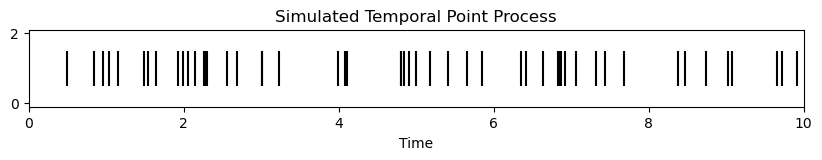

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class ThinningAlgorithm:
    def __init__(self, time_horizon, upper_bound_rate, kernel=None):
        self.time_horizon = time_horizon
        self.upper_bound_rate = upper_bound_rate
        if kernel is None:
            # Default to exponential kernel with decay parameter 1.0
            self.kernel = lambda t: np.exp(-t)
        else:
            self.kernel = kernel

    def simulate(self):
        events = []
        current_time = 0

        while current_time < self.time_horizon:
            # Sample the next candidate event time from a Poisson process with the upper bound rate
            inter_event_time = np.random.exponential(1 / self.upper_bound_rate)
            current_time += inter_event_time

            if current_time >= self.time_horizon:
                break

            # Compute the intensity at the current time
            intensity = self.kernel(current_time - np.array(events)).sum() if events else 0
            mu = 1.0  # Baseline intensity
            total_intensity = mu + intensity

            # Accept the candidate event with probability proportional to the current intensity
            if np.random.uniform(0, 1) < total_intensity / self.upper_bound_rate:
                events.append(current_time)

        return events

# Function to simulate a temporal point process using the thinning algorithm
def simulate_temporal_point_process(time_horizon, upper_bound_rate, kernel=None):
    thinning_algorithm = ThinningAlgorithm(time_horizon, upper_bound_rate, kernel)
    return thinning_algorithm.simulate()

# Example usage
time_horizon = 10.0
upper_bound_rate = 5.0  # Upper bound of the rate
events = simulate_temporal_point_process(time_horizon, upper_bound_rate)
print("Simulated event times:", events)

# Plotting the event times
plt.figure(figsize=(10, 1))
plt.eventplot(events, orientation='horizontal', colors='black')
plt.xlim(0, time_horizon)
plt.xlabel('Time')
plt.title('Simulated Temporal Point Process')
plt.show()


Simulated event times: [0.34490000000000004, 0.9578000000000001, 0.9645, 1.2107, 1.7021000000000002, 1.9027, 1.9694, 1.9708, 2.0976, 2.1692, 2.2739000000000003, 2.3943000000000003, 2.5348, 2.5955, 2.6966, 2.7247000000000003, 2.8055000000000003, 2.807, 3.0388, 3.0468, 3.2452, 3.3906, 3.6178000000000003, 3.7379000000000002, 3.8925, 4.2441, 4.285200000000001, 4.335100000000001, 4.3993, 4.554600000000001, 4.6582, 4.6886, 4.7338000000000005, 5.1818, 5.3513, 5.6715, 5.8655, 5.891, 5.9057, 5.925800000000001, 5.9327000000000005, 5.9852, 6.0829, 6.105, 6.1607, 6.5743, 6.8689, 6.9198, 6.942, 7.0669, 7.414000000000001, 7.4164, 7.6089, 8.5398, 8.649600000000001, 8.6639]


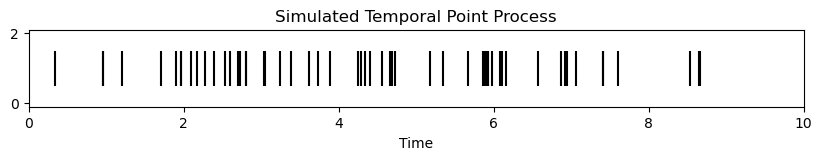

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class DiscreteTimeThinningAlgorithm:
    def __init__(self, time_horizon, upper_bound_rate, delta=0.001, kernel=None):
        self.time_horizon = time_horizon
        self.upper_bound_rate = upper_bound_rate
        self.delta = delta
        if kernel is None:
            # Default to exponential kernel with decay parameter 1.0
            self.kernel = lambda t: np.exp(-t)
        else:
            self.kernel = kernel

    def simulate(self):
        events = []
        num_intervals = int(self.time_horizon / self.delta)
        potential_events = []

        # Step 1: Generate potential events using the base process
        for i in range(num_intervals):
            current_time = i * self.delta
            if np.random.uniform(0, 1) < self.delta * self.upper_bound_rate:
                potential_events.append(current_time)

        # Step 2: Thinning
        for event_time in potential_events:
            intensity = self.kernel(event_time - np.array(events)).sum() if events else 0
            mu = 1.0  # Baseline intensity
            total_intensity = mu + intensity

            # Accept the candidate event with probability proportional to the current intensity
            if np.random.uniform(0, 1) < total_intensity / self.upper_bound_rate:
                events.append(event_time)

        return events

# Function to simulate a temporal point process using the discrete-time thinning algorithm
def simulate_temporal_point_process(time_horizon, upper_bound_rate, delta=0.001, kernel=None):
    thinning_algorithm = DiscreteTimeThinningAlgorithm(time_horizon, upper_bound_rate, delta, kernel)
    return thinning_algorithm.simulate()

# Example usage
time_horizon = 10.0
upper_bound_rate = 5.0  # Upper bound of the rate
delta = 0.0001  # Interval size
events = simulate_temporal_point_process(time_horizon, upper_bound_rate, delta)
print("Simulated event times:", events)

# Plotting the event times
plt.figure(figsize=(10, 1))
plt.eventplot(events, orientation='horizontal', colors='black')
plt.xlim(0, time_horizon)
plt.xlabel('Time')
plt.title('Simulated Temporal Point Process')
plt.show()


In [3]:
## Data

### Non-homogeneous Poisson point process

In [10]:
import numpy as np

def sample_event_time(intensity_func, events, h, step_size):
    t = 0
    while True:
        t += step_size
        prob = intensity_func(t, events) * step_size
        if np.random.random() < prob:
            return t
        if t > h:
            return h

def sample_inhomogeneous_point_process(h, intensity_func, step_size=0.001):
    # Input: time horizon h > 0, intensity function
    # Output: list of event times
    events = []
    t = 0
    while t < h:
        t_next = sample_event_time(intensity_func, events, h, step_size)
        t += t_next
        if t < h:  # If the updated time is within the time horizon, add it to the list
            events.append(t)
    return events

# Example intensity function
def example_intensity_func(t, events):
    # A simple intensity function that increases with the number of past events
    base_rate = 1.0 if t < 0.5 else 10.0
    return base_rate + 0.1 * len(events)

# Example usage
time_horizon = 10.  # Time horizon h > 0
sample = sample_inhomogeneous_point_process(time_horizon, example_intensity_func)
print("Sampled event times:", sample)


Sampled event times: [0.5040000000000003, 0.9160000000000006, 1.3730000000000009, 2.2420000000000018, 2.556000000000002, 3.2150000000000025, 3.656000000000003, 3.913000000000003, 4.110000000000003, 4.454000000000003, 5.1860000000000035, 5.418000000000004, 5.999000000000004, 6.085000000000004, 6.169000000000004, 6.246000000000004, 6.388000000000004, 6.601000000000004, 6.860000000000005, 7.393000000000005, 7.517000000000005, 7.615000000000005, 7.954000000000005, 8.059000000000005, 8.303000000000004, 8.623000000000005, 8.756000000000006, 8.791000000000006, 9.043000000000006, 9.141000000000007, 9.388000000000007, 9.601000000000008, 9.742000000000008]


In [11]:
import numpy as np

def sample_event_time(intensity_func, events, h, step_size):
    t = 0
    cumulative_intensity = 0
    target = np.random.exponential(1)  # Sample from the exponential distribution with rate 1
    
    while True:
        if t >= h:
            return h
        intensity = intensity_func(t, events)
        cumulative_intensity += intensity * step_size
        t += step_size
        if cumulative_intensity >= target:
            return t

def sample_inhomogeneous_point_process(h, intensity_func, step_size=0.001):
    # Input: time horizon h > 0, intensity function
    # Output: list of event times
    events = []
    t = 0
    while t < h:
        t_next = sample_event_time(intensity_func, events, h, step_size)
        t += t_next
        if t < h:  # If the updated time is within the time horizon, add it to the list
            events.append(t)
    return events

# Example intensity function
def example_intensity_func(t, events):
    # A simple intensity function that increases with the number of past events
    base_rate = 1.0 if t < 0.5 else 10.0
    return base_rate + 0.1 * len(events)

# Example usage
time_horizon = 10.  # Time horizon h > 0
sample = sample_inhomogeneous_point_process(time_horizon, example_intensity_func)
print("Sampled event times:", sample)


Sampled event times: [0.4240000000000003, 0.8110000000000006, 0.9250000000000007, 1.5130000000000012, 2.216000000000002, 2.585000000000002, 2.6080000000000023, 3.139000000000003, 3.481000000000003, 3.725000000000003, 3.8980000000000032, 3.9170000000000034, 4.372000000000003, 4.5610000000000035, 4.876000000000004, 5.466000000000005, 5.677000000000005, 5.743000000000005, 5.999000000000005, 6.135000000000005, 6.624000000000006, 6.844000000000006, 7.0190000000000055, 7.2690000000000055, 7.377000000000005, 7.679000000000006, 7.885000000000006, 8.337000000000007, 8.392000000000007, 8.402000000000006, 8.975000000000007, 9.173000000000007, 9.685000000000008]


### Thinning

In [17]:

def sample_inhomogeneous_point_process(h, intensity_func, upper_bound):
    base_process = sample_homogeneous_point_process(h = h, lambda_rate = upper_bound)
    events = []
    for t in base_process:
        if t >= h:
            break
        if np.random.uniform(0, 1) < intensity_func(t, events) / upper_bound:
            events.append(t)
    return events


# Example intensity function
def example_intensity_func(t, events):
    # A simple intensity function that increases with the number of past events
    base_rate = 1.0 if t < 0.5 else 10.0
    return base_rate + 0.1 * len(events)

# Example usage
time_horizon = 10.  # Time horizon h > 0
upper_bound = 100.0
sample = sample_inhomogeneous_point_process(time_horizon, example_intensity_func, upper_bound)
print("Sampled event times:", sample)

Sampled event times: [0.46635384868672547, 0.7973886708451243, 0.9939056443280186, 1.387105851855678, 1.674633768513446, 1.6972896813701739, 1.8969272231569285, 1.9781475072817216, 2.0295078534570736, 2.07548573855767, 2.1884931024003214, 2.3104370150303444, 2.3398159745312888, 2.441095396548345, 2.5128611122253384, 2.5793266253340925, 2.6370576391338822, 2.651326541465175, 2.718623530361973, 2.7265995409452537, 3.0298922615378188, 3.032672600427821, 3.054718558497951, 3.151953336502613, 3.2250676405532777, 3.2912452607187603, 3.3652875465231036, 3.438682153933884, 3.535756734879823, 3.6308785940270916, 3.9228861044404373, 3.9415709617490915, 3.954924086029462, 3.998532764012619, 4.121618328499305, 4.619530005456972, 4.622709209777496, 4.708586651629293, 4.792005746804166, 4.799014444032891, 4.83301560014458, 4.934272377687133, 5.075089062132944, 5.1228283507096295, 5.182527208166317, 5.191735566916588, 5.2708832111062165, 5.2909166340548275, 5.6867957141304935, 5.7109893271942065, 5.7